<a href="https://colab.research.google.com/github/i-ganza007/Sentiment_Analysis_Formative/blob/main/LSTM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ianganza_imdb_sentiment_analysis_path = kagglehub.dataset_download('ianganza/imdb-sentiment-analysis')

print('Data source import complete.')


In [ ]:
!pip install gensim numpy==1.24.4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, Masking
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 67.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 31.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.4 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.2

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-10-04 08:56:28.742277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759568189.081220      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759568189.170260      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
data = '/kaggle/input/imdb-sentiment-analysis/IMDB Dataset.csv'
df = pd.read_csv(data)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_rev'] = df['review'].apply(preprocess_text)

df[['review', 'clean_rev']].head()

,review,clean_rev
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


In [ ]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
train_sec_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['sentiment'])
print(f"Train size: {len(train_sec_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")



Train size: 32000
Validation size: 8000
Test size: 10000


In [ ]:
import nltk
train_sec_df['tokens'] = train_sec_df['clean_rev'].apply(word_tokenize)
val_df['tokens'] = val_df['clean_rev'].apply(word_tokenize)
test_df['tokens'] = test_df['clean_rev'].apply(word_tokenize)

train_sec_df[['clean_rev', 'tokens']].head()



,clean_rev,tokens
26680,oh yes agree others describe appalling acting ...,"[oh, yes, agree, others, describe, appalling, ..."
16648,basic hook lincoln slow slowness represents th...,"[basic, hook, lincoln, slow, slowness, represe..."
29967,utter trash im huge fan cusacks sole reason wa...,"[utter, trash, im, huge, fan, cusacks, sole, r..."
34122,meet cosmo jason priestley nerdy young bookie ...,"[meet, cosmo, jason, priestley, nerdy, young, ..."
823,dont know people criticise show muchit great f...,"[dont, know, people, criticise, show, muchit, ..."


In [ ]:
w2v_model = Word2Vec(sentences=train_sec_df['tokens'], vector_size=200, window=6, min_count=2)

def tokens_to_sequence(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return vectors

X_train_seq_w2v = train_sec_df['tokens'].apply(tokens_to_sequence).tolist()
X_val_seq_w2v = val_df['tokens'].apply(tokens_to_sequence).tolist()
X_test_seq_w2v = test_df['tokens'].apply(tokens_to_sequence).tolist()

In [ ]:
max_len = 100
vector_size = 200

X_train_seq_padded = pad_sequences(X_train_seq_w2v, maxlen=max_len,
                                   dtype='float32',padding='post',
                                   truncating='post', value=0.0)
X_val_seq_padded = pad_sequences(X_val_seq_w2v, maxlen=max_len,
                                 dtype='float32',padding='post',
                                 truncating='post', value=0.0)
X_test_seq_padded = pad_sequences(X_test_seq_w2v, maxlen=max_len,
                                  dtype='float32',padding='post',
                                  truncating='post', value=0.0)



In [ ]:
model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_len, vector_size)),
    Bidirectional(LSTM(256, return_sequences=True,
                       kernel_regularizer=regularizers.l2(0.0005))),
    Dropout(0.4),
    Bidirectional(LSTM(128, kernel_regularizer=regularizers.l2(0.0005))),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer= Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(X_train_seq_padded,
                    train_sec_df['sentiment'].values,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val_seq_padded, val_df['sentiment'].values))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.7582 - loss: 0.9680 - val_accuracy: 0.8390 - val_loss: 0.5183
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.8394 - loss: 0.5043 - val_accuracy: 0.8479 - val_loss: 0.4184
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.8508 - loss: 0.4294 - val_accuracy: 0.8485 - val_loss: 0.4074
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.8580 - loss: 0.3972 - val_accuracy: 0.8580 - val_loss: 0.3765
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.8664 - loss: 0.3806 - val_accuracy: 0.8596 - val_loss: 0.3716
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 498s 996ms/step - accuracy: 0.8641 - loss: 0.3718 - val_accuracy: 0.8699 - val_loss: 0.3532
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 497s 994ms/step - accuracy: 0.8729 - loss: 0.3581 - val_accuracy: 0.8683 - val_loss: 0.3558
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.8735 - loss: 0.3580 - va

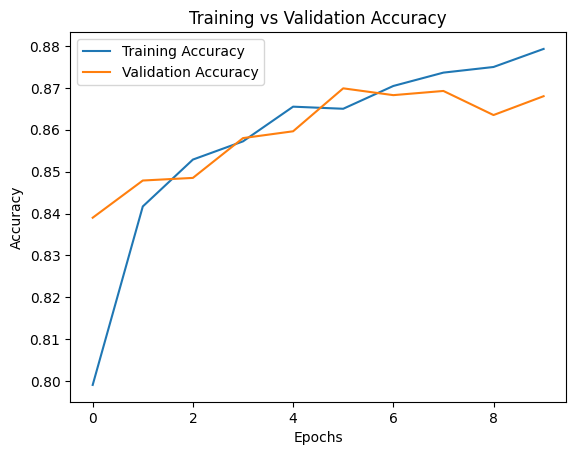

In [ ]:


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df['sentiment'].values,
                            bilstm_preds,
                            target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87      5000
    Positive       0.88      0.85      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



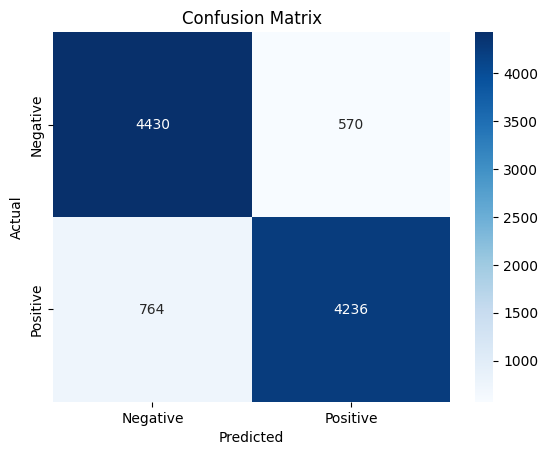

In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_df['sentiment'].values, bilstm_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
